# Testing the effect of the SBM strcture by encoder

Create simulation

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from pygsig.datasets.brownian import Simulation

pp = np.arange(0.01,0.06,0.01)

seq_dataset = []
simulations = []

for p in tqdm(pp):
    sim = Simulation(num_nodes=300,
                     num_blocks=3,
                     p_across_blocks=p,
                     p_within_blocks=0.05,
                     mu = 0.1,
                     beta = 1.0,
                     sigma = 2.0,
                     omega_noise = 0.1,
                     time_horizon= 10,
                     task='classification',
                     dt=1e-1)
    sim.run(graph_seed=29,omega_seed=29,param_seed=29)
    seq_dataset.append(sim.get_sequence())
    simulations.append(sim)

torch.save(seq_dataset,'datasets/brownian/1d-3b-LF-test.pt')

100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


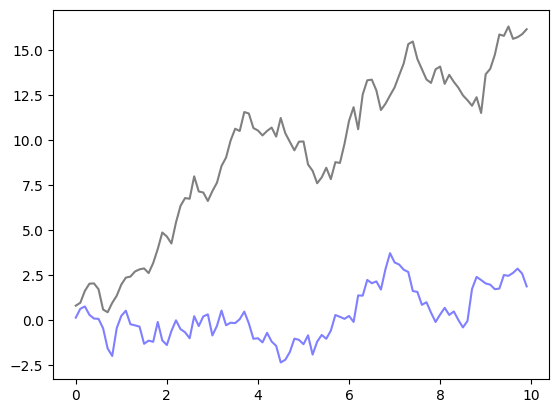

In [2]:
import matplotlib.pyplot as plt

plt.plot(sim.tt,sim.X[np.random.randint(sim.num_nodes)],alpha=0.5,color='black')
plt.plot(sim.tt,sim.X[np.random.randint(sim.num_nodes)],alpha=0.5,color='blue')
plt.show()

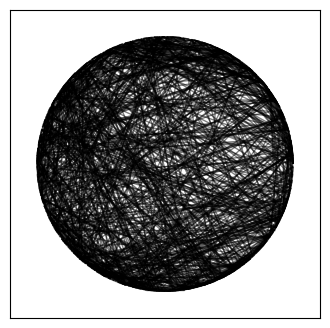

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

idx = 0
plt.figure(figsize=(4,4))
G = nx.from_edgelist(seq_dataset[idx].edge_index.numpy().T)
pos = nx.circular_layout(G) 
nx.draw_networkx_edges(G, pos,alpha=0.5)
plt.show()

Train, baby, train!

In [4]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification,SigGCNClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = 1
out_channels = seq_dataset[0].y.shape[1]
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 1000

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_accuracy = []
all_models_confusion = []

# create models 
min_depth = 4
max_depth = 4
min_hidden_layers = 1
max_hidden_layers = 1

for depth in range(min_depth,max_depth+1):
    print(f'Signature depth: {depth}')
    dataset = []
    for seq in tqdm(seq_dataset):
        signature_transform = SignatureFeatures(sig_depth=depth, normalize=True, log_signature=False,lead_lag=True)
        dataset.append(signature_transform(seq))

    for num_layers in range(min_hidden_layers,max_hidden_layers+1):
        in_channels = signature_channels(2*dim,depth)
        model = GCNClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Name: {model._get_name()}')
        print(f"Number of parameters: {num_params}")
        print(f"Number of layers: {num_layers+1}")
        print(f"Signature depth: {depth}")
        print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
        all_model_parameters.append(num_params)
        all_model_layers.append(num_layers+1)
        all_model_depths.append(depth)
        
        criterion = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
        train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
        eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
        accuracy = np.zeros([num_splits, num_runs, num_trials])
        recall = np.zeros([num_splits, num_runs, num_trials])
        precision = np.zeros([num_splits, num_runs, num_trials])
        f1 = np.zeros([num_splits, num_runs, num_trials])
        confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

        with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
            splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
            for split in range(num_splits):
                train_indices, eval_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                eval_mask[eval_indices] = True
                test_mask[test_indices] = True
                for run, data in enumerate(dataset):
                    for trial in range(num_trials):
                        model.reset_parameters()
                        for epoch in range(num_epochs):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(data.x, data.edge_index)
                            train_loss = criterion(out[train_mask], data.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                                train_losses[split, run, trial, epoch] = train_loss.item()
                                eval_losses[split, run, trial, epoch] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')
                        pbar.update(1)
                        # compute the errors on the testing loss after the last epoch
                        with torch.no_grad():
                            out = model(data.x, data.edge_index)
                            accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                            confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
        all_models_accuracy.append(accuracy)
        all_models_confusion.append(confusion)

Signature depth: 4


100%|██████████| 5/5 [00:00<00:00, 62.78it/s]


Name: GCNClassification
Number of parameters: 2179
Number of layers: 2
Signature depth: 4
Splits: 5, Trials: 4, Runs: 5, Epochs: 1000


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


Dataframe with all results

In [5]:
import pandas as pd
import numpy as np

# Collecting data in a list of dictionaries
data = []
# Populate the data list
for idx in range(len(all_models_accuracy)):
    for split in range(all_models_accuracy[0].shape[0]):
        for run in range(all_models_accuracy[0].shape[1]):
            for trial in range(all_models_accuracy[0].shape[2]):
                # Extract MAE and RMSE for the current model, split, and run
                accuracy_value = all_models_accuracy[idx][split, run, trial]
                num_layers = all_model_layers[idx]
                depth = all_model_depths[idx]
                num_params = all_model_parameters[idx]
                intra_block = pp[run]
                
                # Append the data as a dictionary
                data.append({
                    'SigDepth': depth,
                    'NumLayers': num_layers,
                    'NumParams': num_params,
                    'Split': split,
                    'Run': run,
                    'IntraBlock': intra_block,
                    'Trial': trial,
                    'Accuracy': accuracy_value,
                })

df_sig = pd.DataFrame(data)

## TS2Vec

Train encoder

In [ ]:
import torch

import torch
import numpy as np
from tqdm import tqdm
from pygsig.datasets.brownian import Simulation
from ts2vec.ts2vec import TS2Vec


seq_dataset = []
simulations = []

n_trials = 1

for trial in range(n_trials):
    sim = Simulation(num_nodes=120,
                     num_blocks=3,
                     p_across_blocks=0.05,
                     p_within_blocks=0.1,
                     mu = 0.1,
                     beta = 1.0,
                     sigma = 2.0,
                     omega_noise = 0.1,
                     time_horizon= 100,
                     task='classification',
                     dt=1e-1)
    sim.run(graph_seed=31+trial,omega_seed=31+trial,param_seed=31+trial)
    seq_dataset.append(sim.get_sequence())
    simulations.append(sim)


X_train = torch.stack([torch.stack([snapshot.x for snapshot in seq]) for seq in seq_dataset]).view(-1,seq_dataset[0].snapshot_count,1).numpy()

from ts2vec.ts2vec import TS2Vec
import signatory

encoder = TS2Vec(
    input_dims=1,
    device='cpu',
    hidden_dims=64,
    output_dims=30,
    batch_size=32,
)


loss_log = encoder.fit(
    X_train,
    verbose=True,
)

# Save the encoder
torch.save(encoder,'encoders/TS2VecLite')

In [6]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)



num_nodes = seq_dataset[0].num_nodes
dim = 1
in_channels = dataset[0].num_node_features
out_channels = seq_dataset[0].y.shape[1]
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 200

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_accuracy = []
all_models_confusion = []

# create models 
min_hidden_layers = 2
max_hidden_layers = 2

depth = 4


encoder = torch.load('encoders/TS2VecLite.pt')
dataset = []
for seq in tqdm(seq_dataset):
    ts = torch.stack([snapshot.x for snapshot in seq]).view(-1,seq.snapshot_count,1).numpy()
    x = torch.tensor(encoder.encode(ts, encoding_window='full_series'))
    data = Data(x=x,edge_index=seq.edge_index,edge_weight=seq.edge_weight,y=seq.y)
    dataset.append(data)

for num_layers in range(min_hidden_layers,max_hidden_layers+1):
    model = GCNClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Name: {model._get_name()}')
    print(f"Number of parameters: {num_params}")
    print(f"Number of layers: {num_layers+1}")
    print(f"Signature depth: {depth}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    all_model_parameters.append(num_params)
    all_model_layers.append(num_layers+1)
    all_model_depths.append(depth)
    
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    accuracy = np.zeros([num_splits, num_runs, num_trials])
    recall = np.zeros([num_splits, num_runs, num_trials])
    precision = np.zeros([num_splits, num_runs, num_trials])
    f1 = np.zeros([num_splits, num_runs, num_trials])
    confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                        confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())

    all_models_accuracy.append(accuracy)
    all_models_confusion.append(confusion)

100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Name: GCNClassification
Number of parameters: 6339
Number of layers: 3
Signature depth: 4
Splits: 5, Trials: 4, Runs: 5, Epochs: 200


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


In [7]:
import pandas as pd
import numpy as np

# Collecting data in a list of dictionaries
data = []
# Populate the data list
for idx in range(len(all_models_accuracy)):
    for split in range(all_models_accuracy[0].shape[0]):
        for run in range(all_models_accuracy[0].shape[1]):
            for trial in range(all_models_accuracy[0].shape[2]):
                # Extract MAE and RMSE for the current model, split, and run
                accuracy_value = all_models_accuracy[idx][split, run, trial]
                num_layers = all_model_layers[idx]
                depth = all_model_depths[idx]
                num_params = all_model_parameters[idx]
                intra_block = pp[run]
                
                # Append the data as a dictionary
                data.append({
                    'SigDepth': depth,
                    'NumLayers': num_layers,
                    'NumParams': num_params,
                    'Split': split,
                    'Run': run,
                    'IntraBlock': intra_block,
                    'Trial': trial,
                    'Accuracy': accuracy_value,
                })

# Create the DataFrame from the list of dictionaries
df_ts2vec = pd.DataFrame(data)

## Baseline

In [8]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = 1
out_channels = seq_dataset[0].y.shape[1]
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 400

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_accuracy = []
all_models_confusion = []

# create models 
min_hidden_layers = 1
max_hidden_layers = 1

# create data
in_channels = 30
dataset = []
for seq in tqdm(seq_dataset):
    x = torch.randn(seq.num_nodes,in_channels)
    new_graph = Data(x=x,edge_index=seq.edge_index,edge_weight=seq.edge_weight,y=seq.y)
    dataset.append(new_graph)

for num_layers in range(min_hidden_layers,max_hidden_layers+1):
    model = GCNClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Name: {model._get_name()}')
    print(f"Number of parameters: {num_params}")
    print(f"Number of layers: {num_layers+1}")
    print(f"Signature depth: {depth}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    all_model_parameters.append(num_params)
    all_model_layers.append(num_layers+1)
    all_model_depths.append(depth)
    
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    accuracy = np.zeros([num_splits, num_runs, num_trials])
    confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                        confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())

    all_models_accuracy.append(accuracy)
    all_models_confusion.append(confusion)

100%|██████████| 5/5 [00:00<00:00, 2810.44it/s]


Name: GCNClassification
Number of parameters: 2179
Number of layers: 2
Signature depth: 4
Splits: 5, Trials: 4, Runs: 5, Epochs: 400


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


In [9]:
import pandas as pd
import numpy as np

# Collecting data in a list of dictionaries
data = []
# Populate the data list
for idx in range(len(all_models_accuracy)):
    for split in range(all_models_accuracy[0].shape[0]):
        for run in range(all_models_accuracy[0].shape[1]):
            for trial in range(all_models_accuracy[0].shape[2]):
                # Extract MAE and RMSE for the current model, split, and run
                accuracy_value = all_models_accuracy[idx][split, run, trial]
                num_layers = all_model_layers[idx]
                depth = all_model_depths[idx]
                num_params = all_model_parameters[idx]
                intra_block = pp[run]
                
                # Append the data as a dictionary
                data.append({
                    'SigDepth': depth,
                    'NumLayers': num_layers,
                    'NumParams': num_params,
                    'Split': split,
                    'Run': run,
                    'IntraBlock': intra_block,
                    'Trial': trial,
                    'Accuracy': accuracy_value,
                })

# Create the DataFrame from the list of dictionaries
df_rand = pd.DataFrame(data)

load if needed

In [1]:
import pandas as pd

df_sig = pd.read_json('results/brownian_sig_1d_3b_sbm.json')
df_ts2vec = pd.read_json('results/brownian_ts2vec_1d_3b_sbm.json')
df_rand = pd.read_json('results/brownian_rand_1d_3b_sbm.json')

In [10]:
df_sig['Encoder'] = 'Sig'
df_ts2vec['Encoder'] = 'TS2Vec'
df_rand['Encoder'] = 'Random'
df = pd.concat([df_sig, df_ts2vec, df_rand])
df.reset_index(drop=True, inplace=True)
df.to_json('results/brownian_1d_3b_sbm_trial2.json')

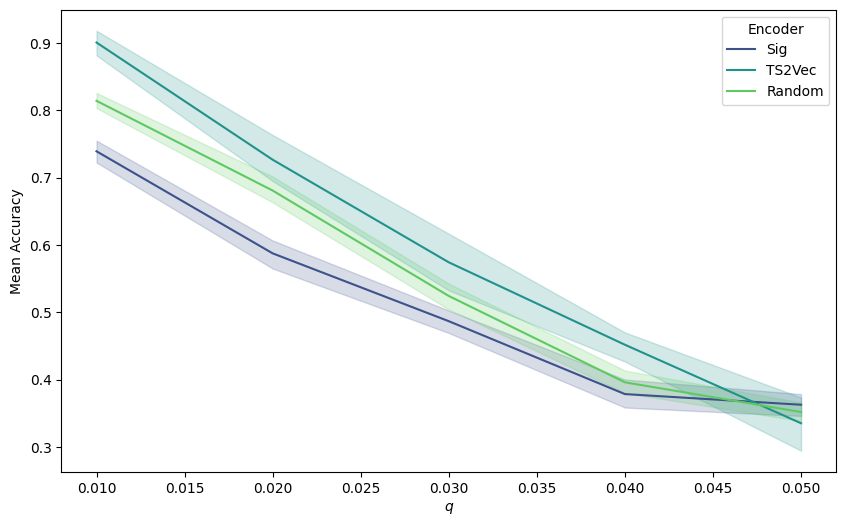

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='IntraBlock', y='Accuracy',data=df,hue='Encoder',palette='viridis')
plt.xlabel('$q$')
plt.ylabel('Mean Accuracy')
plt.show()